<a href="https://colab.research.google.com/github/morganLantrade/Projets_machine_learning/blob/main/projet_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP : Multi-Layer Perceptron 

## Fonctionnement d'un MLP sur un échantillon

<a href="https://www.researchgate.net/figure/Multilayer-perceptron-MLP-architecture-with-two-hidden-layers-and-one-prediction-output_fig1_349630467"><img src="https://www.researchgate.net/publication/349630467/figure/fig1/AS:995457505447936@1614346972386/Multilayer-perceptron-MLP-architecture-with-two-hidden-layers-and-one-prediction-output.png" alt="Multilayer perceptron (MLP) architecture with two hidden layers and one prediction output."/></a>

## Fonctionnement d'un neurone d'une couche d'un perceptron

<a href="https://www.researchgate.net/figure/La-structure-dun-neurone-artificiel_fig3_303447451"><img src="https://www.researchgate.net/profile/Safae-Laqrichi/publication/303447451/figure/fig3/AS:644326015123459@1530630701780/La-structure-dun-neurone-artificiel.png" alt="3-La structure d'un neurone artificiel"/></a>

#### Importations

In [1]:
import sklearn
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs, make_circles

warnings.filterwarnings('ignore')

### Fonction d'activation

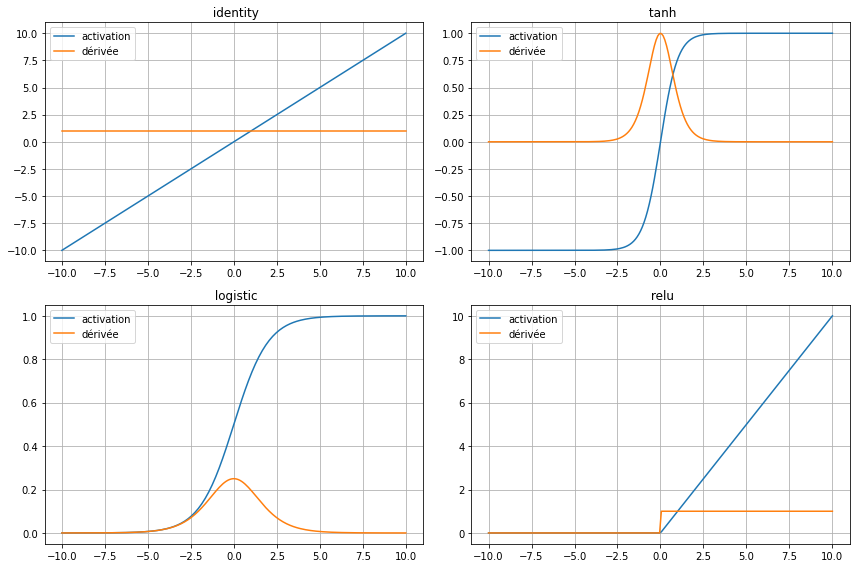

In [2]:
def identity(Z):
    return Z

def d_identity(A):
    return np.ones((A.shape))

def sigmoide(Z):
    return 1/(1+np.exp(-Z))

def d_sigmoide(A):
    return A*(1-A)

def tanh(Z): 
    return (np.exp(Z) - np.exp(-Z))/(np.exp(Z) + np.exp(-Z))

def d_tanh(A):
    return 1-A*A

def relu(Z):
    return np.where(Z>0,Z,0)

def d_relu(A):
    return np.where(A>0,1,0)


ACTIVATIONS={'identity' : (identity,d_identity) ,'logistic' : (sigmoide,d_sigmoide),
             'tanh': (tanh,d_tanh),'relu': (relu,d_relu)}

def afficherActivations(activations):
    i=0
    x=np.linspace(-10,10,200)
    fig, axs = plt.subplots(2,2)
    fig.set_figheight(8)
    fig.set_figwidth(12)
    for nom,a in activations.items():
        axs[i%2,i//2].plot(x,a[0](x),label='activation')
        axs[i%2,i//2].plot(x,a[1](a[0](x)),label='dérivée')
        axs[i%2,i//2].set_title(f' {nom}')
        axs[i%2,i//2].legend()
        axs[i%2,i//2].grid(True)
        i+=1
    fig.tight_layout()
afficherActivations(ACTIVATIONS)


        

<div class="alert alert-block alert-info">
<b>Remarque:</b> La liste d'activations est non éxhaustive et le choix de l'activation dépend du type de problème ( régression , classification ( binaire / multiclasse ) , ...
On commençera par implémenter avec la fonction sigmoïde et on essayera pour une classification binaire des couches cachées différentes et garder la derniere couche sigmoïde (pour finir entre 0 et 1).</div>

### Fonctions coût 

$$\begin{alignat}{2} L_{MSE}=& \frac{1}{m}.\sum_{k=1}^{m} (y_k-a_k)^2\\
L_{log\_loss}=& -\frac{1}{m}.\sum_{k=1}^{m} y_{k}.ln(a_{k})+(1-y_k).ln(1-a_k)\\
\end{alignat}$$

### Dérivées coût

$$\begin{alignat}{2} 
(L_{MSE})'=& \frac{2}{m}.\sum_{k=1}^{m} (a_k-y_k)\\
(L_{log\_loss})' =& -\frac{1}{m}.\sum_{k=1}^m \frac{y_k-a_k}{a_k(1-a_k)})\\
\end{alignat}$$

In [3]:
def MSE_cost(A,y):
    return 1/y.shape[1]*np.sum((y-A)**2)

def log_loss(A,y,eps=10**(-15)):  #eps car log n'est pas définie en 0
    return - 1/y.shape[1]* np.sum(y *np.log(A+eps) + (1 - y) * np.log(1-A+eps))

def d_MSE_cost(A,y): #la somme 1 à m sera faite en produit matriciel
    return 2/y.shape[1]*(A-y)

def d_log_loss(A,y): #la somme de 1 à m sera faite en produit matriciel
    return -1/y.shape[1]*(y-A)/(A*(1-A))

COSTS={ 'log_loss':(log_loss,d_log_loss),'MSE': (MSE_cost,d_MSE_cost)}

### Formes de nos données vectorisées pour une couche L:
- m échantillons 
- $n^{[L-1]}$ variables  en entrée 
- $n^{[L]}$ en sortie 

$$\begin{alignat}{2} A^{[0]}= X = & \underbrace{\begin{bmatrix}
x_{1,1} & x_{1,2}&...& x_{1,m}\\
... &  ...&   ...&   ...&\\
x_{n^{[0]},1} & x_{n^{[0]},2}&...& x_{n^{[0]},m}
\end{bmatrix}}_{(n^{[0]},m)}\\
Y = & \underbrace{\begin{bmatrix}
y_{1} & y_{2} &... &y_{m}\end{bmatrix}}_{(1,m)}\\
W^{[L]} = & \underbrace{\begin{bmatrix}w_{1,1} & w_{1,2} &... &w_{1,n^{[L-1]}}\\
... & ... &... &...\\
w_{n^{[L]},1} & w_{n^{[L]},2} &... &w_{n^{[L]},n^{[L-1]}}\\
\end{bmatrix}}_{(n^{[L]},n^{[L-1]})}
\end{alignat}$$

### Forward propagation 

$$
\forall j \in \{1,...,n^{[L]}\} : neurones\\
\forall k \in \{1,...,m\} : échantillons
$$ 

$$\begin{alignat}{2} z^{[L]}_{jk} = & \sum_{i=1}^{n^{[L-1]}} w^{[L]}_{ji}.a^{[L-1]}_{ik} + b_j^{[L]}\\
\newline
\underbrace{Z}_{(n^{[L]},m)}^{[L]}  = & \begin{bmatrix}
\sum_{i=1}^{n^{[L-1]}} \color{red}w^{[L]}_{1,i}.\color{green}a^{[L-1]}_{i,1} + \color{blue}b_1^{[L]} &, &\sum_{i=1}^{n^{[L-1]}} \color{red}w^{[L]}_{1,i}.\color{green}a^{[L-1]}_{i,2} + \color{blue}b_1^{[L]} &, &... &, &\sum_{i=1}^{n^{[L-1]}} \color{red}w^{[L]}_{1,i}.\color{green}a^{[L-1]}_{im} + \color{blue}b_1^{[L]}\\
... &,  &... &, &... &,  & ...\\
\sum_{i=1}^{n^{[L-1]}} \color{red}w^{[L]}_{n^{[L]},i}.\color{green}a^{[L-1]}_{i,1} + \color{blue}b^{[L]}_{n^{[L]}} &, &\sum_{i=1}^{n^{[L-1]}}\color{red}w^{[L]}_{n^{[L]},i}.\color{green}a^{[L-1]}_{i,2} + \color{blue}b^{[L]}_{n^{[L]}} &, &... &, &\sum_{i=1}^{n^{[L-1]}} \color{red}w^{[L]}_{n^{[L]},i}.\color{green}a^{[L-1]}_{i,m} + \color{blue}b^{[L]}_{n^{[L]}}\\
\end{bmatrix}\\
\newline
\underbrace{Z}_{(n^{[L]},m)}^{[L]} = &\underbrace{\color{red}{\begin{bmatrix}w^{[L]}_{1,1} & w^{[L]}_{1,2} &... &w^{[L]}_{1,n^{[L]}}\\
... & ... &... &...\\
w^{[L]}_{n^{[L]},1} & w^{[L]}_{n^{[L]},2} &... &w^{[L]}_{n^{[L]},n^{[L]}}\\
\end{bmatrix}}}_{(n^{[L]},n^{[L-1]})}.\underbrace{\color{green}{\begin{bmatrix}
a^{[L-1]}_{1,1} & a^{[L-1]}_{1,2}&...& a^{[L-1]}_{1,m}\\
... &  ...&   ...&   ...&\\
a_{n^{[L-1]},1} & a^{[L-1]}_{n^{[L-1]},2}&...& a^{[L-1]}_{n^{[L-1]},m}
\end{bmatrix}}}_{(n^{[L-1]},m)} + \underbrace{\color{blue}{\begin{bmatrix}
b_1^{[L]} & b_1^{[L]} & ... & b_1^{[L]}\\
... & ... & ... & ...\\
b^{[L]}_{n^{[L]}} & b^{[L]}_{n^{[L]}} & ... & b^{[L]}_{n^{[L]}}\end{bmatrix}}}_{(n^{[L]},m)}\\
\underbrace{Z}_{(n^{[L]},m)}^{[L]} = & W^{[L]}.A^{[L-1]}+B^{[L]} \\
\newline
\underbrace{A}^{[L]}_{(n^{[L]},m)}= &\frac{1}{1+e^{-Z^{[L]}}} \\
\end{alignat}$$

<div class="alert alert-block alert-success">
On obtient les activations où les lignes correspondent aux neurones et colonnes aux échantillons.</div>


<div class="alert alert-block alert-info">
<b>Remarque :</b>  Avec numpy , on peut additionner un tableau avec un entier donc b peut être réduit à une seul élément par neurone c'est a dire une shape de ($n^{[L]}$,1)</div>

### Backward propagation à K couches
- activation : <span style="color:green"> **sigmoide** </span> 
- cost : <span style="color:brown"> **log_loss** </span>

#### Calcul des dérivées de la derniere couche K : 


$$
\begin{alignat}{5}
\require{cancel}
&\underbrace{\frac{\partial L}{\partial W^{[K]}}}_{(n^{[K]},n^{[K-1]})} &= &\color{red}{\frac{\partial L}{\partial A^{[K]}} }.\color{green}{\frac{\partial A^{[K]}}{\partial Z^{[K]}}}.\color{blue}{\frac{\partial Z^{[K]}}{\partial W^{[K]}}}\\
&\underbrace{\frac{\partial L}{\partial B^{[K]}}}_{(n^{[K]},1)} &= &\color{red}{\frac{\partial L}{\partial A^{[K]}}} . \color{green}{\frac{\partial A^{[K]}}{\partial Z^{[K]}}}.\color{blue}{\frac{\partial Z^{[K]}}{\partial B^{[K]}}}\\
&\underbrace{\color{blue}{\frac{\partial Z^{[K]}}{\partial W^{[K]}}}}_{(n^{[K-1]},m)} &= & A^{[K-1]}\\
&\underbrace{\color{blue}{\frac{\partial Z^{[K]}}{\partial B^{[K]}}}}_{(n^{[K-1]},1)} &= & 1\\
&\color{red}{\frac{\partial L}{\partial a^{[K]}_{ji}} }&= &-\frac{1}{m}.\sum_{k=1}^m \frac{y_k-a^{[K]}_{jk}}{a^{[K]}_{jk}(1-a^{[K]}_{jk})}\\
&\color{green}{\underbrace{\frac{\partial a^{[K]}_{ji}}{\partial z^{[K]}}}_{(n^{[K]},m)}}&= & a^{[K]}_{ji}*(1-a^{[K]}_{ji})\\
&\color{brown}{\frac{\partial L}{\partial {z_{jk}}^{[K]}}}& =&\color{red}{\frac{\partial L}{\cancel{\partial a^{[K]}_{ji}}} }.\color{green}{\frac{\cancel{\partial a^{[K]}_{ji}}}{\partial {z_{jk}}^{[K]}}}= \color{brown}{\frac{1}{m}.\sum_{k=1}^m (a_{jk}-y_k)}\\
\newline
\newline
&\underbrace{\frac{\partial L}{\partial W^{[K]}}}_{(n^{[K]},n^{[K-1]})} &= &\boxed{\color{brown}{\underbrace{(A^{[K]}-y)}_{(n^{[K]},m)}} .\color{blue}{\underbrace{{}^TA^{[K-1]}}_{(m,n^{[K-1]})}}}\\
&\underbrace{\frac{\partial L}{\partial B^{[K]}}}_{(n^{[K]},1)} &=  &\boxed{\color{brown}{\frac{1}{m}.\sum_{k=1}^m (a_{jk}-y_k)}} \\
\end{alignat}$$

<div class="alert alert-block alert-info">
<b>Même principe que la propagation avant :</b>
$$(A^{[K]}-y).{}^TA^{[K-1]}$$ Le produit matriciel permet de vectoriser la somme de 1 à m .</div>


#### Calcul des dérivées de la couche L

$$
\begin{alignat}{5}
&\underbrace{\frac{\partial L}{\partial W^{[L]}}}_{(n^{[L]},n^{[L-1]})} &= &\color{purple}{\frac{\partial L}{\partial Z^{[L]}}}.\color{blue}{\frac{\partial Z^{[L]}}{\partial W^{[L]}}}  \\
&\color{purple}{\frac{\partial L}{\partial Z^{[L]}}}& = &\color{gray}{\frac{\partial L}{\partial Z^{[L+1]}}}. \color{orange}{\frac{\partial Z^{[L+1]}}{\partial A^{[L]}}} .  \color{green}{\frac{\partial A^{[L]}}{\partial Z^{[L]}}} \\
& &=&\underbrace{\underbrace{\color{orange}{{}^TW^{[L+1]}}}_{(n^{[L]},n^{[L+1]})}.\underbrace{\color{grey}{\frac{\partial L}{\partial Z^{[L+1]}}}}_{(n^{[L+1]},m)}. \underbrace{\color{green}{A^{[L]}*(1- A^{[L]})}}_{(n^{[L]},m)}}_{(n^{[L]},m)}\\
\newline
&\underbrace{\frac{\partial L}{\partial W^{[L]}}}_{(n^{[L]},n^{[L-1]})} &= &\boxed{\underbrace{\color{orange}{{}^TW^{[L+1]}}}_{(n^{[L]},n^{[L+1]})}.\underbrace{\color{grey}{\frac{\partial L}{\partial Z^{[L+1]}}}}_{(n^{[L+1]},m)}. \underbrace{\color{green}{A^{[L]}*(1- A^{[L]})}}_{(n^{[L]},m)}.\color{blue}{\underbrace{{}^TA^{[L-1]}}_{(m,n^{[L-1]})}}}\\
&\underbrace{\frac{\partial L}{\partial B^{[L]}}}_{(n^{[L]},1)} &=  &\boxed{\color{purple}{\sum _{k=0}^{m} \frac{\partial L}{\partial Z^{[L]}}}}  \text{par ligne}\\
\end{alignat}$$


<div class="alert alert-block alert-success">
Nous avons réussi à exprimer les gradients de la couche L-1 par ceux de la couche L, nous pouvons donc maintenant récursivement
remonter jusqu a la couche 0.
Nous avons maintenant toutes les formules pour implémenter notre MLP avec une activation : sigmoïde et un cout : log_loss.</div>


### Implémentation du modèle

In [54]:
def initParam(X,hidden_layer=[]):
    '''Retourne une liste des poids de notre modeles
       une liste des biais de notre modeles
       longueur = longueur hidden_layer + 1'''
    couches= [X.shape[0]]+hidden_layer+[1]
    coefs=[]
    biais=[]
    for i in range(1,len(couches)):
        coefs.append(np.random.randn(couches[i],couches[i-1]))
        biais.append(np.random.randn(couches[i],1))
    return coefs,biais


def forwardPropagation(X,coefs,biais,activation='logistic',cost='log_loss'):
    '''Retourne une liste d'activations ou l'indice correspondant a la couche
    A[0]=X '''
    K=len(coefs)
    activations=[X]
    for i in range(1,K+1):
        W=coefs[i-1]
        b=biais[i-1]
        Z=W.dot(activations[i-1])+b
        A=ACTIVATIONS[activation][0](Z) if i!=K else sigmoide(Z) # on finit sur une sigmoide
        activations.append(A)
    return activations


def predict(X,coefs,bais):
    '''Seuil 0.5 pour la sigmoide'''
    A=forwardPropagation(X,coefs,bais)[len(coefs)] # derniere couche
    return np.where(A>0.5,1.,0.) 

def predict_proba(X,coefs,bais):
    A=forwardPropagation(X,coefs,bais)[len(coefs)] # derniere couche
    return A


def backwardPropagation(X,y,coefs,biais,activations,activation='logistic',cost='log_loss'):
    '''Retourne une liste des gradients de W et de b ou 
    l'indice correspondant à la couche i-1
    '''
    K=len(coefs)
    m=X.shape[1]
    les_dZ= [COSTS[cost][1](activations[K],y) * ACTIVATIONS[activation][1](activations[K])] #nous allons devoir stocker les dZ pour notre rétroPropagation 
    dWs= [les_dZ[0].dot(activations[K-1].T)]  #et la premiere propagation arriere est sigmoide
    dBs=[(1/m if cost=='log_loss' else 2/m) * np.sum(les_dZ[0],axis=1,keepdims=True)]
    for L in range(1,K):
        W=coefs[K-L]
        b=biais[K-L]
        A=activations[K-L]
        dZ= 1/m * (W.T).dot(les_dZ[L-1])*ACTIVATIONS[activation][1](A) #dérivée de la fonction activation
        les_dZ.append(dZ)
        dWs.insert(0,dZ.dot(activations[K-L-1].T))
        dBs.insert(0,np.sum(dZ,axis=1,keepdims=True))
    return dWs,dBs

def mAj(coefs,biais,dWs,dBs,alpha):
    for L in range(len(coefs)):
        coefs[L]=coefs[L]-alpha*dWs[L]
        biais[L]=biais[L]-alpha*dBs[L]
        
def learn_affichage(Xa,ya,Xt,yt,hidden_layer=[16,8,4],alpha=0.1, iter=200,bid=1,activation='logistic',cost='log_loss'):
    '''Fonction fit de notre modele qui mémorise les courbes d aprentissage'''
    coefs,biais=initParam(Xa,hidden_layer)
    stop=False
    k=0
    couts_A,couts_t,scores_A,scores_t=[],[],[],[]
    while k<iter:
        les_A=forwardPropagation(Xa,coefs,biais,activation,cost)
        dWs,dBs=backwardPropagation(Xa,ya,coefs,biais,les_A,activation,cost)
        mAj(coefs,biais,dWs,dBs,alpha)
        k+=1
        # pour diminuer le nombre de calculs
        if k%bid==0: 
            #sauvegarde des données pour le tracé des courbes d'apprentissages et de loss
            couts_A.append(COSTS[cost][0](les_A[len(coefs)],ya))
            couts_t.append(COSTS[cost][0](forwardPropagation(Xt,coefs,biais,activation,cost)[len(coefs)],yt))
            scores_A.append(accuracy_score(ya[0],predict(Xa,coefs,biais)[0]))
            scores_t.append(accuracy_score(yt[0],predict(Xt,coefs,biais)[0]))
           
            
    return coefs,biais,couts_A,couts_t,scores_A,scores_t

def afficherApprentissage(couts_A,couts_t,scores_A,scores_t,bid=1,W=[],b=[],Xa=[],Xt=[],ya=[],yt=[]):
    '''Fonction d'affichage de l"apprentrissage'''
    X= [ x*bid for x in range(len(couts_A))] #nombre d'itérations
    fig, axs = plt.subplots(1,(2 if not W else 3)) #cas classification binaire
    fig.set_figheight(5)
    fig.set_figwidth(18)
    axs[0].plot(X,couts_A,label='loss apprentissage')
    axs[0].plot(X,couts_t,label='loss test')
    axs[0].set_title('Loss curve')
    axs[0].set_xlabel('itérations')
    axs[0].set_ylabel('cost')
    axs[0].legend()
    axs[1].plot(X,scores_A,label='score apprentissage')
    axs[1].plot(X,scores_t,label='score test')
    axs[1].set_title(f'Learning curve')
    axs[1].set_xlabel('itérations')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()
    if W:
        cmp = np.array(['g','b'])
        axs[2].scatter(Xa[0,:],Xa[1,:],c=ya,s=50,alpha=0.2)
        axs[2].scatter(Xt[0,:],Xt[1,:],c=yt,s=50)
        nx, ny = 200, 200
        x_min, x_max = axs[2].get_xlim()
        y_min, y_max = axs[2].get_ylim()
        xx, yy = np.meshgrid(np.linspace(x_min,x_max, nx),np.linspace(y_min,y_max, ny))
        axs[2].set_title(f'Frontiere')
        Z = predict_proba(np.c_[xx.ravel(), yy.ravel()].T,W,b)
        Z=Z[0, :].reshape(xx.shape)
        # dessiner le contour correspondant à la frontière proba = 0,5
        plt.contourf(xx, yy, Z, [0,0.5,1],colors=['rosybrown','papayawhip'])
        plt.scatter(Xa[0,:],Xa[1,:],c=ya,s=50,alpha=0.2)
        plt.scatter(Xt[0,:],Xt[1,:],c=yt,s=50)
 




### Testons sur une classification binaire 

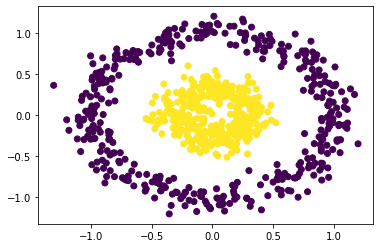

In [55]:
Xa, ya = make_circles(n_samples=800, noise=0.10, factor=0.3, random_state=0)
Xt, yt = make_circles(n_samples=200, noise=0.10, factor=0.3, random_state=0)
Xa = Xa.T
Xt=Xt.T
ya = ya.reshape(ya.shape[0])

plt.scatter(Xa[0, :], Xa[1, :], c=ya)
plt.show()
ya = ya.reshape(1,ya.shape[0])
yt = yt.reshape(1,yt.shape[0])


In [56]:
def afficherFrontiere(Xa,Xt,ya,yt):
    # créer une nouvelle figure
    plt.figure()
    cmp = np.array(['g','b'])
    # afficher les nuages de points d'apprentissage (pleins) et de test (creux)
    # suivant la classe, les points affichés sont rouges ou verts 
    plt.scatter(Xa[0,:],Xa[1,:],c=ya,s=50,alpha=0.2)
    plt.scatter(Xt[0,:],Xt[1,:],c=yt,s=50)
    # calculer la probabilité de sortie du MLP pour tous les points du plan
    nx, ny = 200, 200
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min,x_max, nx),np.linspace(y_min,y_max, ny))
    Z = predict_proba(np.c_[xx.ravel(), yy.ravel()].T,W,b)
    Z=Z[0, :].reshape(xx.shape)
    # dessiner le contour correspondant à la frontière proba = 0,5
    plt.contour(xx, yy, Z, [0,0.5,1],colors=['rosybrown','papayawhip'])
    plt.scatter(Xa[0,:],Xa[1,:],c=ya,s=50,alpha=0.2)
    plt.scatter(Xt[0,:],Xt[1,:],c=yt,s=50)
    plt.show()
    



#### Une couche : Un neurone

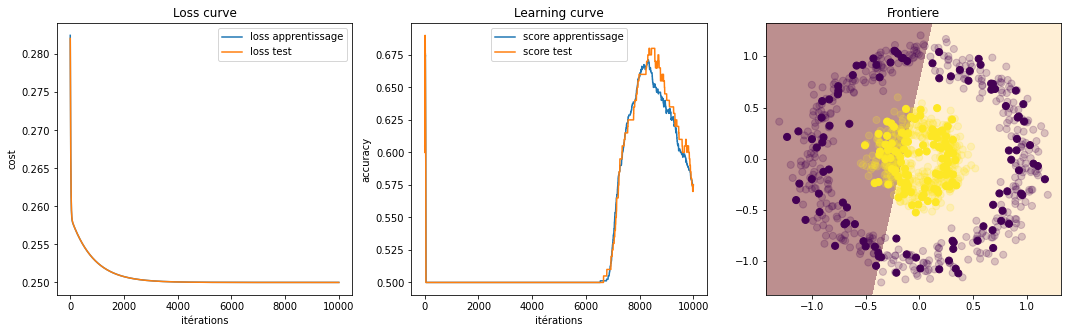

In [63]:
W,b,cA,ct,sA,st= learn_affichage(Xa,ya,Xt,yt,[],0.2,100000,10,cost='MSE')
afficherApprentissage(cA,ct,sA,st,1,W,b,Xa,Xt,ya,yt)

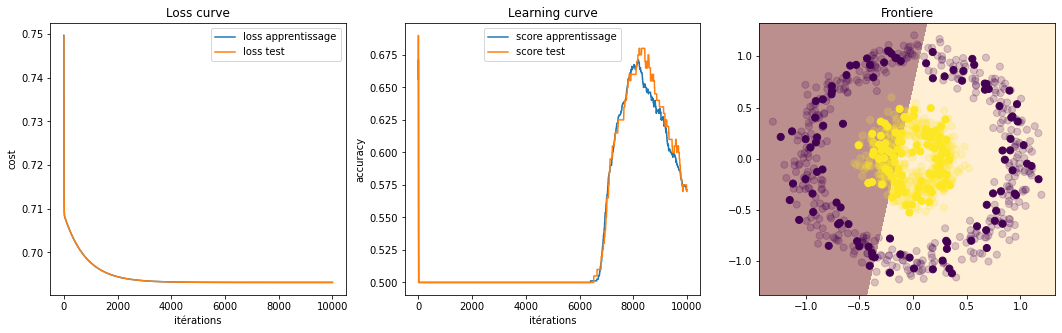

In [64]:
W,b,cA,ct,sA,st= learn_affichage(Xa,ya,Xt,yt,[],0.2,100000,10,cost='log_loss')
afficherApprentissage(cA,ct,sA,st,1,W,b,Xa,Xt,ya,yt)

<div class="alert alert-block alert-warning">
On essaye de séparer linéaire : impossible
</div>

#### Deux couches : Plusieurs neurones

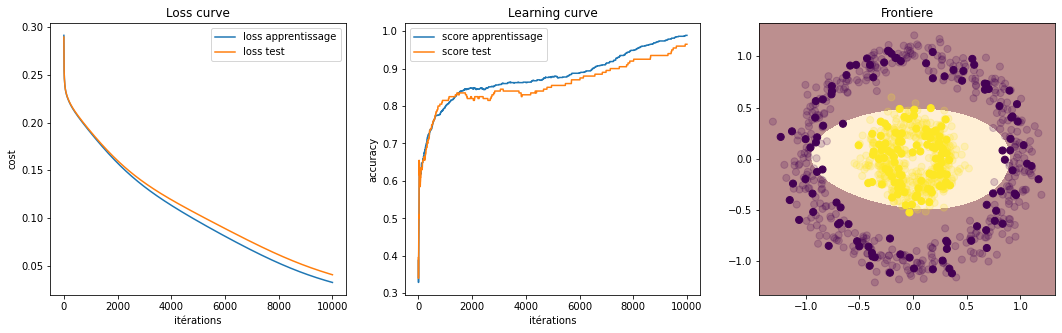

In [59]:
W,b,cA,ct,sA,st= learn_affichage(Xa,ya,Xt,yt,[4],0.2,100000,10,cost='MSE')
afficherApprentissage(cA,ct,sA,st,1,W,b,Xa,Xt,ya,yt)

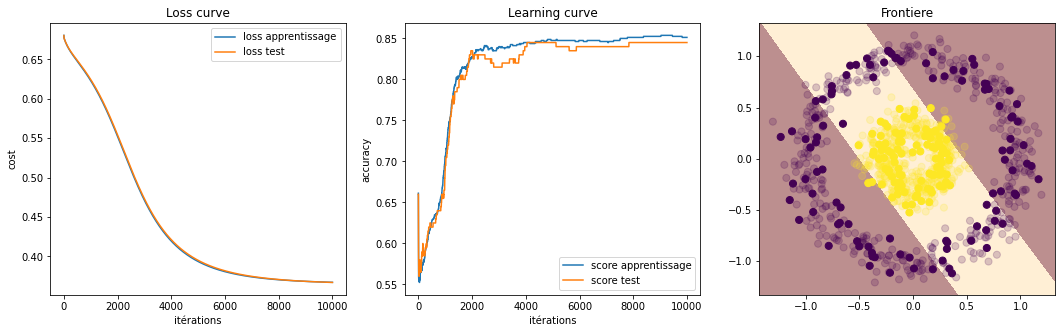

In [60]:
W,b,cA,ct,sA,st= learn_affichage(Xa,ya,Xt,yt,[4],0.2,100000,10,cost='log_loss')
afficherApprentissage(cA,ct,sA,st,1,W,b,Xa,Xt,ya,yt)

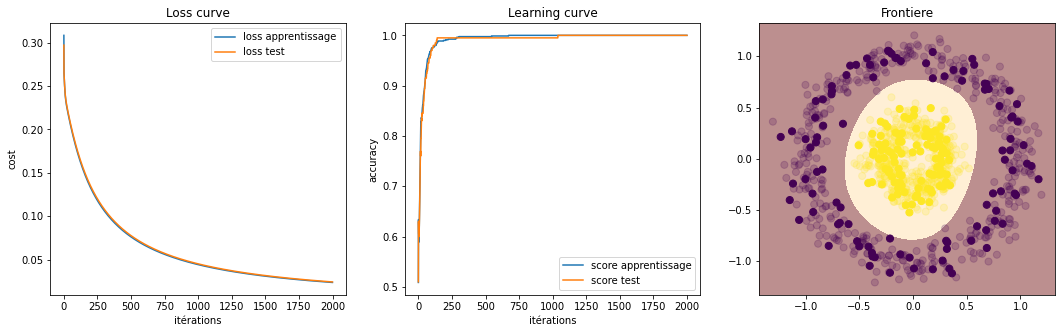

In [61]:
W,b,cA,ct,sA,st= learn_affichage(Xa,ya,Xt,yt,[32],0.2,20000,10,cost='MSE')
afficherApprentissage(cA,ct,sA,st,1,W,b,Xa,Xt,ya,yt)

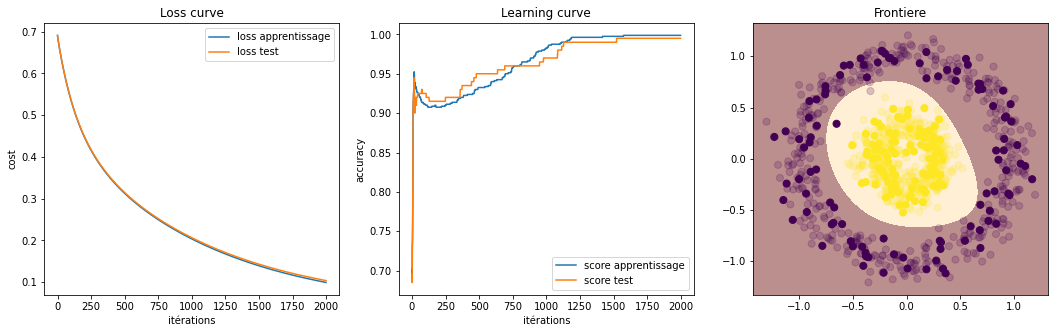

In [62]:
W,b,cA,ct,sA,st= learn_affichage(Xa,ya,Xt,yt,[32],0.2,20000,10,cost='log_loss')
afficherApprentissage(cA,ct,sA,st,1,W,b,Xa,Xt,ya,yt)

<div class="alert alert-block alert-success">
A partir de 16 neurones le modèle semble efficace.</div>